This notebook aims to compare a model built with HARK.ConsumptionSaving tools, and a model built with the GenericModel class.

In [5]:
from HARK.distribution import Lognormal
from HARK.simulation import GenericModel
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
import matplotlib.pyplot as plt
import numpy as np

Recall that the Perfect Foresight equations are as follows:

\begin{eqnarray*}
v_t(m_t) &=& \max_{c_t} {~} u(c_t) + \DiscFac (1-\DiePrb_{t+1})  \mathbb{E}_{t} \left[ (\PermGroFac_{t+1}\psi_{t+1})^{1-\CRRA} v_{t+1}(m_{t+1}) \right], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \text{$\underline{a}$}, \\
m_{t+1} &=& \Rfree/(\PermGroFac_{t+1} \psi_{t+1}) a_t + \theta_{t+1}, \\
(\psi_{t+1},\theta_{t+1}) &\sim& F_{t+1}, \\
\mathbb{E}[\psi]=\mathbb{E}[\theta] &=& 1, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}.
\end{eqnarray*}

With the following parameters:



| Parameter | Description | Code | Example value | Time-varying? |
| :---: | --- | --- | --- | --- |
| $\DiscFac$ |Intertemporal discount factor  | $\texttt{DiscFac}$ | $0.96$ |  |
| $\CRRA$|Coefficient of relative risk aversion | $\texttt{CRRA}$ | $2.0$ | |
| $\Rfree$ | Risk free interest factor | $\texttt{Rfree}$ | $1.03$ | |
| $1 - \DiePrb_{t+1}$ |Survival probability | $\texttt{LivPrb}$ | $[0.98]$ | $\surd$ |
|$\PermGroFac_{t+1}$|Permanent income growth factor|$\texttt{PermGroFac}$| $[1.01]$ | $\surd$ |
| $\sigma_\psi$| Standard deviation of log permanent income shocks | $\texttt{PermShkStd}$ | $[0.1]$ |$\surd$ |
| $N_\psi$| Number of discrete permanent income shocks | $\texttt{PermShkCount}$ | $7$ | |
| $\sigma_\theta$| Standard deviation of log transitory income shocks | $\texttt{TranShkStd}$ | $[0.2]$ | $\surd$ |
| $N_\theta$| Number of discrete transitory income shocks | $\texttt{TranShkCount}$ | $7$ |  |
| $\mho$ | Probability of being unemployed and getting $\theta=\underline{\theta}$ | $\texttt{UnempPrb}$ | $0.05$ |  |
| $\underline{\theta}$| Transitory shock when unemployed | $\texttt{IncUnemp}$ | $0.3$ |  |
| $\mho^{Ret}$ | Probability of being "unemployed" when retired | $\texttt{UnempPrb}$ | $0.0005$ |  |
| $\underline{\theta}^{Ret}$| Transitory shock when "unemployed" and retired | $\texttt{IncUnemp}$ | $0.0$ |  |
| $(none)$ | Period of the lifecycle model when retirement begins | $\texttt{T_retire}$ | $0$ | |
| $(none)$ | Minimum value in assets-above-minimum grid | $\texttt{aXtraMin}$ | $0.001$ | |
| $(none)$ | Maximum value in assets-above-minimum grid | $\texttt{aXtraMax}$ | $20.0$ | |
| $(none)$ | Number of points in base assets-above-minimum grid | $\texttt{aXtraCount}$ | $48$ | |
| $(none)$ | Exponential nesting factor for base assets-above-minimum grid | $\texttt{aXtraNestFac}$ | $3$ | |
| $(none)$ | Additional values to add to assets-above-minimum grid | $\texttt{aXtraExtra}$ | $None$ | |
| $\underline{a}$| Artificial borrowing constraint (normalized) | $\texttt{BoroCnstArt}$ | $0.0$ | |
| $(none)$|Indicator for whether $\texttt{vFunc}$ should be computed | $\texttt{vFuncBool}$ | $True$ | |
| $(none)$ |Indicator for whether $\texttt{cFunc}$ should use cubic splines | $\texttt{CubicBool}$ | $False$ |  |
|$T$| Number of periods in this type's "cycle" |$\texttt{T_cycle}$| $1$ | |
|(none)| Number of times the "cycle" occurs |$\texttt{cycles}$| $0$ | |

First, let's build and solve the normal perfect foresight model.

In [6]:
IdiosyncDict={
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Intertemporal discount factor
    "LivPrb" : [0.98],                     # Survival probability
    "PermGroFac" :[1.01],                  # Permanent income growth factor
    
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [0.1],                  # Standard deviation of log permanent shocks to income
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.2],                  # Standard deviation of log transitory shocks to income
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution   
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 1,                         # Number of periods in the cycle for this agent type        
    
    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

isc = IndShockConsumerType(**IdiosyncDict)
isc.solve()

Getting the first solution here:

In [7]:
## Note: the solution argument matches the notation in
##       the model configuration, m_
def first_solution(m_):
    ### This is way more complicated than it should be...
    return isc.solution[0].cFunc(m_).tolist()

In [8]:
first_solution(50)

26.065360369080842

To translate this into the GenericModel configuration:

In [20]:
#####
# IndShockConsumer
#####
 
sample_configuration = {
    'params' : {
        'PermGroFac' : 1.01, # in the original, this is a list. TODO: time-varying params
        'Rfree' : 1.03,
        'UnempPrb' : 0.05,   # Probability of unemployment while working
        'IncUnemp' : 0.3,    # Unemployment benefits replacement rate
        'PermShk' : Lognormal(sigma=0.1), # Leaving out discretization parameter!
        'TranShk' : Lognormal(sigma=0.2)  #
    },
    'states' : {
        'a' : lambda m_, c : m_ - c
    },
    'controls' : {
        'c' : first_solution # consumption.
        # The function is the decision rule.
    },
    'post_states' : {
        'm' : lambda m_, p_, c, Rfree : Rfree * (m_ - c) + p_, #market assets
        'p' : lambda p_, PermGroFac: p_ * PermGroFac # income
    },
    'initial_states' : {
        'p_' : 1,
        'm_' : 1
    }
}

# 'CRRA' : 2.0      - These are used in utility and value function derivations
#'DiscFac' : 0.96    - these are not yet supported for GenericModel

# 'LivPrb' : [0.98]  - Mortality not yet built into the model

# Parameters for 'retirement' -- currently unsupported
#    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
#    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
#    "T_retire" : 0,                        # Period of retirement (0 --> no retirement)


The GenericModel is used just like the other HARK AgentTypes with respect to how simulations are simulated and ran.

In [21]:
generic_model_test = GenericModel(sample_configuration)
generic_model_test.initializeSim()
generic_model_test.simulate()

History is available for the simulated values. All the model variables are tracked.

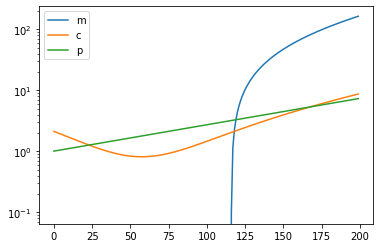

In [22]:
plt.plot(generic_model_test.agent.history['m'], label='m')
plt.plot(generic_model_test.agent.history['c'], label='c')
plt.plot(generic_model_test.agent.history['p'], label='p')
plt.yscale('log')
plt.legend()

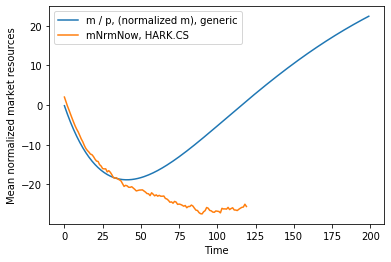

In [34]:
SimulationParams = {
    "AgentCount" : 100,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : 0.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 0.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.01,                 # Aggregate permanent income growth factor
    "T_age" : None,                        # Age after which simulated agents are automatically killed
}

pf(**SimulationParams)

pf.track_vars = ['mNrmNow']
pf.initializeSim()
pf.simulate()


# Plot market resources over time
plt.plot(np.array(
    generic_model_test.agent.history['m']) / np.array(generic_model_test.agent.history['p']),
    label='m / p, (normalized m), generic'
)
plt.plot(np.mean(pf.mNrmNow_hist,axis=1), label="mNrmNow, HARK.CS")
plt.xlabel('Time')
plt.ylabel('Mean normalized market resources')
plt.legend()
plt.show()